In [18]:
import logging
import os
import sys
sys.path.append("../")
import glob
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import monai
from monai.data import ImageDataset, DataLoader
import monai.transforms as transforms
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity
import nibabel as nib
import pandas as pd

from utils.custom_transforms import ScaleIntensityFromHistogramPeak, SetBackgroundToZero, SelectChannelsd

In [2]:
#ROOT_DIR = "/home/fehrdelt/bettik/"
ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

In [3]:
SUB_EXPERIMENT_NAME = "densenet3d_exp_0_0"

### Clinical data (class label) 1: nihss>15, 0: nihss<=15

In [4]:
participants_tsv_path = ROOT_DIR+"datasets/final_soop_dataset_small/participants.tsv"

participants_df = pd.read_csv(participants_tsv_path, sep="\t")

In [5]:
participants_df.head()

,participant_id,sex,age,race,acuteischaemicstroke,priorstroke,bmi,nihss,gs_rankin_6isdeath
0,sub-2,M,78.0,w,1.0,0.0,22.84,17.0,NaN
1,sub-3,F,87.0,w,1.0,1.0,19.23,15.0,6.0
2,sub-5,M,58.0,w,1.0,0.0,37.29,1.0,NaN
3,sub-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# drop rows where 'nihss' is NaN
participants_df = participants_df.dropna(subset=["nihss"])

In [7]:
participants_df.head()

,participant_id,sex,age,race,acuteischaemicstroke,priorstroke,bmi,nihss,gs_rankin_6isdeath
0,sub-2,M,78.0,w,1.0,0.0,22.84,17.0,NaN
1,sub-3,F,87.0,w,1.0,1.0,19.23,15.0,6.0
2,sub-5,M,58.0,w,1.0,0.0,37.29,1.0,NaN
5,sub-8,F,34.0,b,1.0,0.0,23.14,19.0,NaN
6,sub-9,F,70.0,w,1.0,0.0,26.89,18.0,4.0


In [8]:
participants_df["high_nihss"] = (participants_df["nihss"] > 15).astype(np.int64)

participants_df.head()

,participant_id,sex,age,race,acuteischaemicstroke,priorstroke,bmi,nihss,gs_rankin_6isdeath,high_nihss
0,sub-2,M,78.0,w,1.0,0.0,22.84,17.0,NaN,1
1,sub-3,F,87.0,w,1.0,1.0,19.23,15.0,6.0,0
2,sub-5,M,58.0,w,1.0,0.0,37.29,1.0,NaN,0
5,sub-8,F,34.0,b,1.0,0.0,23.14,19.0,NaN,1
6,sub-9,F,70.0,w,1.0,0.0,26.89,18.0,4.0,1


In [9]:
counts = participants_df["high_nihss"].value_counts()
count_high_nihss_1 = int(counts.get(1, 0))
count_high_nihss_0 = int(counts.get(0, 0))

print(f"high_nihss==1: {count_high_nihss_1}")
print(f"high_nihss==0: {count_high_nihss_0}")

high_nihss==1: 209
high_nihss==0: 897


In [10]:
# drop up to 600 rows where high_nihss == 0
n_drop = min(600, count_high_nihss_0)
if n_drop > 0:
    drop_idx = participants_df[participants_df["high_nihss"] == 0].sample(n=n_drop, random_state=42).index
    participants_df = participants_df.drop(drop_idx).reset_index(drop=True)
    # update counts if needed
    counts = participants_df["high_nihss"].value_counts()
    count_high_nihss_1 = int(counts.get(1, 0))
    count_high_nihss_0 = int(counts.get(0, 0))

print(f"After dropping rows:")
print(f"high_nihss==1: {count_high_nihss_1}")
print(f"high_nihss==0: {count_high_nihss_0}")

After dropping rows:
high_nihss==1: 209
high_nihss==0: 297


In [11]:
# Stratified split of participants_df into train/val/test
# Fractions can be adjusted if needed
train_frac, val_frac, test_frac = 0.7, 0.15, 0.15
SPLIT_SEED = 42

assert "high_nihss" in participants_df.columns, "Column 'high_nihss' not found."

rng = np.random.default_rng(SPLIT_SEED)
train_idx, val_idx, test_idx = [], [], []

for cls in participants_df["high_nihss"].unique():
    cls_idx = participants_df.index[participants_df["high_nihss"] == cls].to_numpy()
    cls_idx = rng.permutation(cls_idx)

    n = len(cls_idx)
    n_train = int(np.floor(n * train_frac))
    n_val = int(np.floor(n * val_frac))
    n_test = n - n_train - n_val

    train_idx.extend(cls_idx[:n_train])
    val_idx.extend(cls_idx[n_train:n_train + n_val])
    test_idx.extend(cls_idx[n_train + n_val:])

# Build dataframes
train_participants_df = participants_df.loc[train_idx].reset_index(drop=True)
val_participants_df = participants_df.loc[val_idx].reset_index(drop=True)
test_participants_df = participants_df.loc[test_idx].reset_index(drop=True)

def _dist(df):
    vc = df["high_nihss"].value_counts()
    return f"total={len(df)}, class0={int(vc.get(0,0))}, class1={int(vc.get(1,0))}"

print("Split summary:")
print(f"Train: {_dist(train_participants_df)}")
print(f"Val:   {_dist(val_participants_df)}")
print(f"Test:  {_dist(test_participants_df)}")

Split summary:
Train: total=353, class0=207, class1=146
Val:   total=75, class0=44, class1=31
Test:  total=78, class0=46, class1=32


### Make the images used for classification
Stacking the T2 FLAIR, the anomaly map and the atlas together

In [12]:
anomaly_maps_flair_dir = ROOT_DIR+"datasets/anomaly_maps/exp_1_0/"
flair_dir = ROOT_DIR+"datasets/final_soop_dataset_small/flair_registered/"

anomaly_maps_adc_dir = ROOT_DIR+"datasets/anomaly_maps/exp_1_1/"
adc_dir = ROOT_DIR+"datasets/final_soop_dataset_small/adc_registered/"

registered_atlases_dir = ROOT_DIR+"datasets/final_soop_dataset_small/registered_atlases/"

anomaly_maps_flair_paths = glob.glob(anomaly_maps_flair_dir+"*.nii.gz")
flair_paths = glob.glob(flair_dir+"*.nii.gz")

anomaly_maps_adc_paths = glob.glob(anomaly_maps_adc_dir+"*.nii.gz")
adc_paths = glob.glob(adc_dir+"*.nii.gz")

registered_atlases_paths = glob.glob(registered_atlases_dir+"*.nii.gz")

In [11]:
""" for file in os.listdir(registered_atlases_dir):
    #rename files to have consistent naming
    if "sub-" in file:
        new_file_name = file.replace("_T1w", "")
        os.rename(os.path.join(registered_atlases_dir, file), os.path.join(registered_atlases_dir, new_file_name)) """

' for file in os.listdir(registered_atlases_dir):\n    #rename files to have consistent naming\n    if "sub-" in file:\n        new_file_name = file.replace("_T1w", "")\n        os.rename(os.path.join(registered_atlases_dir, file), os.path.join(registered_atlases_dir, new_file_name)) '

In [13]:
# read the csv to get files to exclude
exclude_csv_path = ROOT_DIR+"StrokeUADiag/data_splits_lists/soop/exclude_failed_registration.csv"
exclude_df = pd.read_csv(exclude_csv_path, header=None)



exclude_files = exclude_df[0].tolist()

print(exclude_files)

['sub-185', 'sub_1303', 'sub-199', 'sub-984', 'sub-1138', 'sub-767', 'sub-1251', 'sub-855', 'sub-1660', 'sub-512', 'sub-1698', 'sub-617', 'sub-1119', 'sub-1183', 'sub-1558', 'sub-279', 'sub-846', 'sub-1610', 'sub-1261', 'sub-1308', 'sub-1717', 'sub-7', 'sub-1041', 'sub-343', 'sub-989', 'sub-605', 'sub-234', 'sub-1203', 'sub-1491', 'sub-949', 'sub-1727']


### Make stacked images (flair image, anomaly map & registered atlas)

In [17]:
def normalize_from_histogram_peak(image, hist_norm_target_value=200.0):
    hist, bins = np.histogram(image, bins=100, range=(np.max(image)/15.0, np.max(image)*0.8))

    # Find the value corresponding to the maximum of the histogram
    most_occurred_pixel_value = bins[np.argmax(hist)]

    image_norm = image/most_occurred_pixel_value*hist_norm_target_value # scale it so the peak is always at hist_norm_target_value
    
    return image_norm

In [12]:
""" 
for ano_flair_map_path in tqdm(anomaly_maps_flair_paths):

    id = os.path.basename(ano_flair_map_path).replace(".nii.gz", "").split('_')[-2]
    
    if id not in exclude_files:

        flair_img_path = flair_dir + id + "_FLAIR.nii.gz"
        adc_img_path = adc_dir + id + "_rec-ADC_dwi.nii.gz"
        ano_adc_map_path = anomaly_maps_adc_dir + f"ano_map_{id}_rec-ADC_dwi.nii.gz"
        registered_atlas_path = registered_atlases_dir + f"{id}.nii.gz"

        output_path = ROOT_DIR+f"datasets/StrokeUADiag_classification_inputs/stacked_{id}.nii.gz"
        if os.path.exists(output_path):
            print(f"Stacked image for ID {id} already exists. Skipping.")
            continue

        # flair
        try:
            flair_nii = nib.load(flair_img_path)
            flair_image = normalize_from_histogram_peak(flair_nii.get_fdata(), hist_norm_target_value=200.0)
        except Exception as e:
            print(f"Error loading FLAIR image for ID {id}: {e}")
            continue
        try:
            ano_map_flair_image = nib.load(ano_flair_map_path).get_fdata()*1800.0
        except Exception as e:
            print(f"Error loading FLAIR anomaly map for ID {id}: {e}")
            continue

        # adc
        try:
            adc_nii = nib.load(adc_img_path)
            adc_image = normalize_from_histogram_peak(adc_nii.get_fdata(), hist_norm_target_value=200.0)
        except Exception as e:
            print(f"Error loading ADC image for ID {id}: {e}")
            continue
        try:
            ano_map_adc_image = nib.load(ano_adc_map_path).get_fdata()*1800.0
        except Exception as e:
            print(f"Error loading ADC anomaly map for ID {id}: {e}")
            continue

        # atlas
        try:
            registered_atlas_image = nib.load(registered_atlas_path).get_fdata()*10.0
        except Exception as e:
            print(f"Error loading registered atlas image for ID {id}: {e}")
            continue

        stacked_data = np.stack([flair_image, ano_map_flair_image, adc_image, ano_map_adc_image, registered_atlas_image], axis=-1)
        np.clip(stacked_data, 0, 1000, out=stacked_data)  # clip values to [0, 1000] to avoid extreme outliers
        stacked_img = nib.Nifti1Image(stacked_data, affine=flair_nii.affine)

        nib.save(stacked_img, output_path)
    
     """

' \nfor ano_flair_map_path in tqdm(anomaly_maps_flair_paths):\n\n    id = os.path.basename(ano_flair_map_path).replace(".nii.gz", "").split(\'_\')[-2]\n    \n    if id not in exclude_files:\n\n        flair_img_path = flair_dir + id + "_FLAIR.nii.gz"\n        adc_img_path = adc_dir + id + "_rec-ADC_dwi.nii.gz"\n        ano_adc_map_path = anomaly_maps_adc_dir + f"ano_map_{id}_rec-ADC_dwi.nii.gz"\n        registered_atlas_path = registered_atlases_dir + f"{id}.nii.gz"\n\n        output_path = ROOT_DIR+f"datasets/StrokeUADiag_classification_inputs/stacked_{id}.nii.gz"\n        if os.path.exists(output_path):\n            print(f"Stacked image for ID {id} already exists. Skipping.")\n            continue\n\n        # flair\n        try:\n            flair_nii = nib.load(flair_img_path)\n            flair_image = normalize_from_histogram_peak(flair_nii.get_fdata(), hist_norm_target_value=200.0)\n        except Exception as e:\n            print(f"Error loading FLAIR image for ID {id}: {e}")

### Model training

In [14]:
num_channels = 5
image_size = 128

In [15]:
labels = []

image_paths = glob.glob(ROOT_DIR+"datasets/StrokeUADiag_classification_inputs/stacked_*.nii.gz")
image_ids = [os.path.basename(path).replace(".nii.gz", "").split('_')[-1] for path in image_paths]
image_ids_df = pd.DataFrame(image_ids, columns=['participant_id'])

# make a new dataframe merging image_ids_df and participants_df on 'participant_id'
merged_df = pd.merge(image_ids_df, participants_df, on='participant_id', how='left')
merged_df.dropna(subset=["high_nihss"], inplace=True)
labels = merged_df['high_nihss'].values

labels = labels.astype(np.int64).tolist()
print(labels)
    

[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 

In [16]:

images = glob.glob(ROOT_DIR+"datasets/StrokeUADiag_classification_inputs/stacked_*.nii.gz")
final_images = [image for image in images if image.split('_')[-1].replace(".nii.gz", "") in merged_df['participant_id'].values]

print(len(images))
print(final_images)

1216
['/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-226.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-93.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-730.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-1608.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-268.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-1564.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-433.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-750.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/StrokeUADiag_classification_inputs/stacked_sub-8.nii.gz', '/bettik/PROJE

In [29]:
train_files = [{"img": img, "label": label} for img, label in zip(final_images[:100], labels[:100])]
#val_files = [{"img": img, "label": label} for img, label in zip(final_images[100:], labels[100:])]

# Define transforms
train_transforms = Compose([
    transforms.LoadImaged(keys=["img"]),
    transforms.EnsureChannelFirstd(keys=["img"]),
    SelectChannelsd(keys=["img"], selected_channels=[2, 4, 1]),
    transforms.RandAffined(keys=["img"], prob=0.5, rotate_range=(0.1, 0.1, 0.1)),
    transforms.RandScaleCropd(keys=["img"], roi_scale=0.9, max_roi_scale=1.1, random_size=True),
    transforms.ResizeWithPadOrCropd(keys=["img"], spatial_size=(image_size, image_size, image_size)),
    transforms.RandFlipd(keys=["img"], spatial_axis=0, prob=0.5),
    #SetBackgroundToZero()
    ])

val_transforms = Compose([
    transforms.LoadImaged(keys=["img"]),
    transforms.EnsureChannelFirstd(keys=["img"]),
    transforms.ResizeWithPadOrCropd(keys=["img"], spatial_size=(image_size, image_size, image_size)),
    #SetBackgroundToZero()
    ])

# Define image dataset, data loader
check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

first = monai.utils.misc.first(check_loader)

print(type(first["img"]), first["label"])

# create a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# create a validation data loader
#val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
#val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())



<class 'monai.data.meta_tensor.MetaTensor'> tensor([0, 0])


In [30]:
sample = train_ds[12]
print(sample["img"].shape)



torch.Size([3, 128, 128, 128])


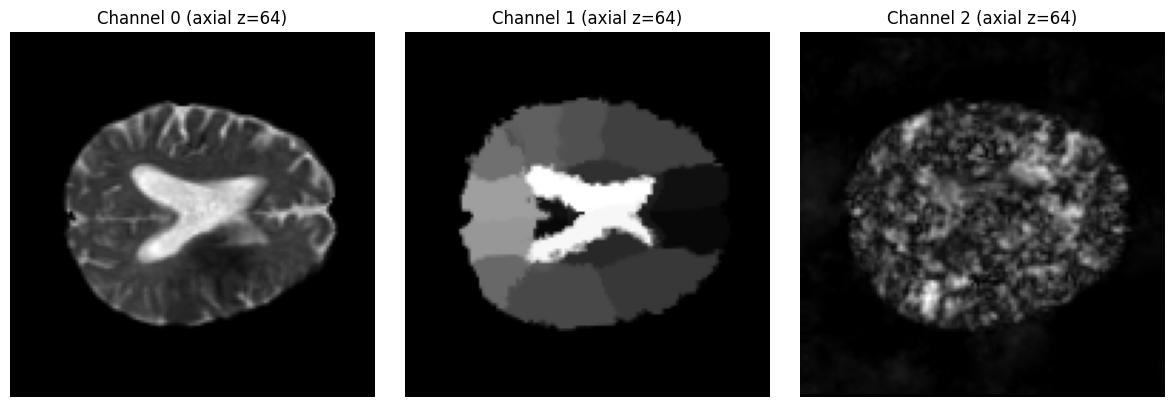

In [31]:
# Display the middle axial slice of the three channels of the sample image
img_t = sample["img"]
img = img_t.detach().cpu().numpy() if torch.is_tensor(img_t) else np.asarray(img_t)

assert img.ndim == 4 and img.shape[0] >= 3, f"Unexpected image shape: {img.shape}"
mid_z = img.shape[-1] // 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].imshow(img[i, :, :, mid_z], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Channel {i} (axial z={mid_z})")
plt.tight_layout()
plt.show()

**Vérif image que le randflip ce soit bon** 

et prendre le nom de l'image, aller voir direct dans le dataset de base vérif que le score nihss est bon

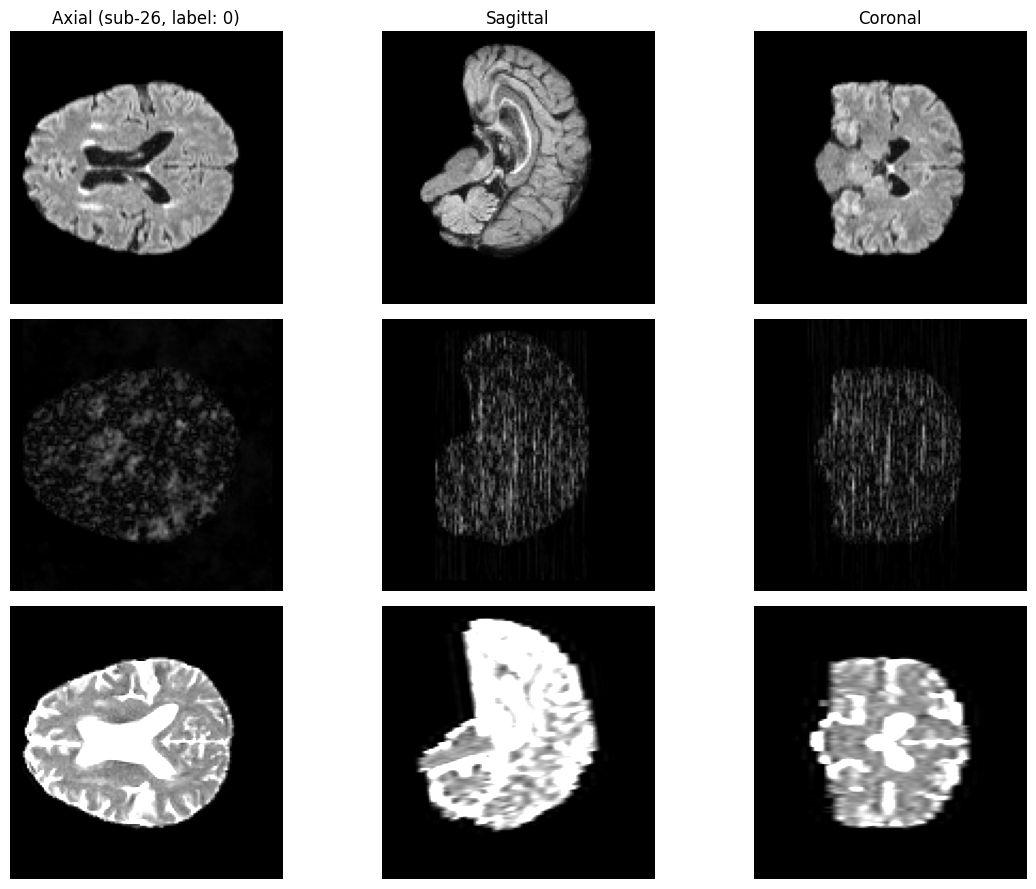

In [ ]:
image_num = 20

def _to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

n_show = 3
fig, axes = plt.subplots(n_show, 3, figsize=(12, 3 * n_show))
if n_show == 1:
    axes = np.expand_dims(axes, 0)



image_name = os.path.basename(final_images[image_num]).replace(".nii.gz", "").split('_')[-1]
sample = train_ds[image_num]
vmax = 450.0

img = _to_numpy(sample["img"])  # expected shape (C, H, W, D)
lbl = sample.get("label", None)

# ------ FLAIR channel ------
c0 = img[0] if img.ndim == 4 else img  # use channel 0 (FLAIR)
H, W, D = c0.shape

axial = c0[:, :, D // 2]          # H x W
sagittal = c0[H // 2, :, :]      # W x D -> transpose for display
coronal = c0[:, W // 2, :]       # H x D -> transpose for display

for j, slc in enumerate([axial, sagittal, coronal]):
    
    
    axes[0, j].imshow(slc, cmap="gray", vmin=0, vmax=vmax)
    axes[0, j].axis("off")

# ------ Ano map ------
c1 = img[1] if img.ndim == 4 else img  # use channel 1 (Ano map)
H, W, D = c1.shape

axial = c1[:, :, D // 2]          # H x W
sagittal = c1[H // 2, :, :]      # W x D -> transpose for display
coronal = c1[:, W // 2, :]       # H x D -> transpose for display

for j, slc in enumerate([axial, sagittal, coronal]):
    
    
    axes[1, j].imshow(slc, cmap="gray", vmin=0, vmax=vmax)
    axes[1, j].axis("off")

# ------- Registered atlas ------
c2 = img[2] if img.ndim == 4 else img  # use channel 2 (Registered atlas)
H, W, D = c2.shape

axial = c2[:, :, D // 2]          # H x W
sagittal = c2[H // 2, :, :]      # W x D -> transpose for display
coronal = c2[:, W // 2, :]       # H x D -> transpose for display

for j, slc in enumerate([axial, sagittal, coronal]):
    
    
    axes[2, j].imshow(slc, cmap="gray", vmin=0, vmax=vmax)
    axes[2, j].axis("off")

# set titles

axes[0, 0].set_title(f"Axial ({image_name}, label: {lbl})")
axes[0, 1].set_title("Sagittal")
axes[0, 2].set_title("Coronal")

plt.tight_layout()
plt.show()

### Model definition

In [23]:

# Create DenseNet121, CrossEntropyLoss and Adam optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=num_channels, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)


### Training

In [24]:
os.makedirs(ROOT_DIR+f"StrokeUADiag/tensorboard/{SUB_EXPERIMENT_NAME}", exist_ok=True)
MODELS_DIR = ROOT_DIR+f"StrokeUADiag/models/{SUB_EXPERIMENT_NAME}/"
os.makedirs(MODELS_DIR, exist_ok=True)
writer = SummaryWriter(ROOT_DIR+f"StrokeUADiag/tensorboard/{SUB_EXPERIMENT_NAME}")

In [25]:

# start a typical PyTorch training
max_epochs = 100
val_interval = 2
best_metric = -1
epoch_loss_values = list()
metric_values = list()


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['img'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data['img'].to(device), val_data['label'].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f"{MODELS_DIR}best_metric_model_classification3d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()


----------
epoch 1/100
epoch 1 average loss: 0.7411
----------
epoch 2/100
epoch 2 average loss: 0.6098
saved new best metric model
current epoch: 2 current accuracy: 0.8482 best accuracy: 0.8482 at epoch 2
----------
epoch 3/100
epoch 3 average loss: 0.5339
----------
epoch 4/100
epoch 4 average loss: 0.4899
current epoch: 4 current accuracy: 0.8482 best accuracy: 0.8482 at epoch 2
----------
epoch 5/100
epoch 5 average loss: 0.4727
----------
epoch 6/100
epoch 6 average loss: 0.4480
saved new best metric model
current epoch: 6 current accuracy: 0.8555 best accuracy: 0.8555 at epoch 6
----------
epoch 7/100
epoch 7 average loss: 0.4241
----------
epoch 8/100
epoch 8 average loss: 0.3966
current epoch: 8 current accuracy: 0.8496 best accuracy: 0.8555 at epoch 6
----------
epoch 9/100
epoch 9 average loss: 0.4017
----------
epoch 10/100
epoch 10 average loss: 0.3734
current epoch: 10 current accuracy: 0.7781 best accuracy: 0.8555 at epoch 6
----------
epoch 11/100
epoch 11 average loss:

KeyboardInterrupt: 

In [17]:
# display image number 48 from the train_loader (0-based indexing)
for sample_idx in range(50):
    batch_size = train_loader.batch_size or 1
    batch_idx, inbatch_idx = divmod(sample_idx, batch_size)

    # get the target batch
    target_batch = None
    for bi, batch in enumerate(train_loader):
        if bi == batch_idx:
            target_batch = batch
            break

    if target_batch is None:
        raise IndexError(f"Index {sample_idx} out of range for train_loader.")

    imgs = target_batch["img"]  # shape: [B, C, H, W, D]
    lbls = target_batch["label"]

    # extract the specific sample from the batch
    img_t = imgs[inbatch_idx]        # shape: [C, H, W, D]
    lbl = int(lbls[inbatch_idx]) if torch.is_tensor(lbls) else int(lbls[inbatch_idx])

    img = _to_numpy(img_t)           # to numpy, shape: [C, H, W, D]
    vmax_disp = 450.0

    def orthogonal_slices(vol):
        H, W, D = vol.shape
        return vol[:, :, D // 2], vol[H // 2, :, :], vol[:, W // 2, :]

    row_titles = ["FLAIR", "Ano map (FLAIR)", "ADC", "Ano map (ADC)", "Atlas"]
    n_rows = min(img.shape[0], len(row_titles))

    fig, axes = plt.subplots(n_rows, 3, figsize=(8, 2 * n_rows))
    if n_rows == 1:
        axes = np.expand_dims(axes, 0)

    for r in range(n_rows):
        axial, sagittal, coronal = orthogonal_slices(img[r])
        for c, slc in enumerate([axial, sagittal, coronal]):
            axes[r, c].imshow(slc, cmap="gray", vmin=0, vmax=vmax_disp)
            axes[r, c].axis("off")

    axes[0, 0].set_title(f"Axial (train idx: {sample_idx}, label: {lbl})")
    axes[0, 1].set_title("Sagittal")
    axes[0, 2].set_title("Coronal")

    for r in range(n_rows):
        axes[r, 0].set_ylabel(row_titles[r], rotation=90, fontsize=10)

    # show the corresponding file id if available
    try:
        img_path = train_files[sample_idx]["img"]
        image_id = os.path.basename(img_path).replace(".nii.gz", "")
        fig.suptitle(f"{image_id}", y=1.02, fontsize=12)
    except Exception:
        pass

    plt.tight_layout()
    plt.show()

NameError: name '_to_numpy' is not defined